In [1]:
!git clone https://github.com/MalinduLiyanage/Buddha_Statue_Inpainting_Pix2Pix.git

Cloning into 'Buddha_Statue_Inpainting_Pix2Pix'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 3), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 3.50 MiB | 7.97 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
checkpoint_dir = '/content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints'

In [3]:
import tensorflow as tf

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),   # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [4]:
import tensorflow as tf

checkpoint_file = '/content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/ckpt-8'

generator = Generator()
checkpoint = tf.train.Checkpoint(generator=generator)

checkpoint.restore(checkpoint_file)
print(f"Checkpoint restored from {checkpoint_file}")

Checkpoint restored from /content/Buddha_Statue_Inpainting_Pix2Pix/training_checkpoints/ckpt-8


In [16]:
def load_single_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    input_image = tf.cast(image, tf.float32) / 127.5 - 1

    return tf.expand_dims(input_image, axis=0)

In [17]:
import matplotlib.pyplot as plt

def generate_and_display(generator, input_image):
    prediction = generator(input_image, training=False)
    input_image = (input_image[0] + 1) / 2
    prediction = (prediction[0] + 1) / 2
    plt.figure(figsize=(10, 5))
    display_list = [input_image, prediction]
    titles = ['Input Image', 'Predicted Image']

    for i, (image, title) in enumerate(zip(display_list, titles)):
        plt.subplot(1, 2, i + 1)
        plt.title(title)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


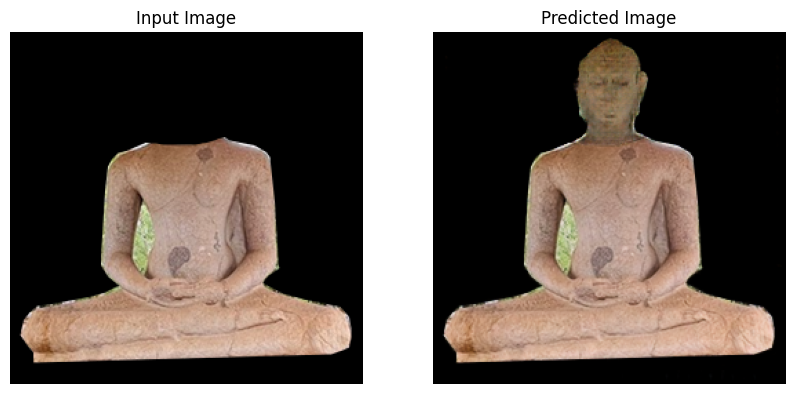

In [19]:
test_image_path = '/content/Buddha_Statue_Inpainting_Pix2Pix/test_data/35.png'
input_image = load_single_image(test_image_path)
generate_and_display(generator, input_image)